# [VQ-VAE](https://arxiv.org/abs/1711.00937) by  [Aäron van den Oord](https://twitter.com/avdnoord) et al. in PyTorch

## Introduction

Variational Auto Encoders (VAEs) can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or seperating out the data. Thus given some data we can think of using a neural network for representation generation.

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

### Code

I have followed the code from the TensorFlow implementation by the author which you can find here [vqvae.py](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py) and [vqvae_example.ipynb](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb).

Another PyTorch implementation is found at [pytorch-vqvae](https://github.com/ritheshkumar95/pytorch-vqvae).


## Basic Idea

The overall architecture is summarized in the diagram below:

![](https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/images/vq-vae.png?raw=1)

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector, i.e. $e_i \in \mathbb{R}^{D}$. The model is comprised of an encoder and a decoder. The encoder will map the input to a sequence of discrete latent variables, whereas the decoder will try to reconstruct the input from these latent sequences.

More preciesly, the model will take in batches of RGB images,  say $x$, each of size 32x32 for our example, and pass it through a ConvNet encoder producing some output $E(x)$, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index.

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed image.

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

## Loss

The total loss is actually composed of three components

1. **reconstruction loss**: which optimizes the decoder and encoder
1. **codebook loss**: due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
1. **commitment loss**:  since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

TODOS:

1. Do PCA on the z's to see if it's low-dimensional
2. Maybe z's are in a union of low-dimensional subspaces.
3. Maybe z entries can be represented by sparse dictionary items.
4. What is the set of the purple vectors to allow efficient reconstruction?
5. The codebook can be quadratic on D instead of exponential.
6. Try the regular dictionary learning first.

In [ ]:
!nvidia-smi

Tue Oct 10 23:23:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install umap-learn
!pip install six

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=fd0f25b29fb1ea95ced08fc01551b86b9128893fd6670d36beff89024c26b3f7
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=0dd4af283afa169e3157f4ff66aebf589bf8a3b978ad1c4f5b06ccd9fe426966
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter


from six.moves import xrange

import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load Data

In [ ]:
training_data = datasets.CIFAR10(root="data", train=True, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.0,0.0,0.0), (1.0,1.0,1.0))
                                  ]))

validation_data = datasets.CIFAR10(root="data", train=False, download=True,
                                  transform=transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.0,0.0,0.0), (1.0,1.0,1.0))
                                  ]))

100%|██████████| 170498071/170498071 [00:13<00:00, 12992914.81it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
# training_data = datasets.SVHN(root="data", split='train', download=True,
#                                   transform=transforms.Compose([
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.0,0.0,0.0), (1.0,1.0,1.0))
#                                   ]))

# validation_data = datasets.SVHN(root="data", split='test', download=True,
#                                   transform=transforms.Compose([
#                                       transforms.ToTensor(),
#                                       transforms.Normalize((0.0,0.0,0.0), (1.0,1.0,1.0))
#                                   ]))

In [ ]:
# size of the training data
training_data_size = len(training_data)
print(training_data_size)

# size of the validation data
validation_data_size = len(validation_data)
print(validation_data_size)

50000
10000


In [ ]:
# variance of the training data
data_variance_training = np.var(training_data.data / 255.0)
print(data_variance_training)

# variance of the validation data
data_variance_validation = np.var(validation_data.data / 255.0)
print(data_variance_validation)

0.06328692405746414
0.06311123249672204


## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be **quantized independently**. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors (see appendix in the original paper) instead of an auxillary loss. This has the **advantage** that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version *trains faster* than the non-EMA version.

In [ ]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost

        '''
        Here the register_buffer() method is typically used to register a buffer
        that should not to be considered a model parameter. For example,
        BatchNorm’s running_mean is not a parameter, but is part of the module’s
        state. Buffers, by default, are persistent and will be saved alongside
        parameters. This behavior can be changed by setting persistent to False.
        The only difference between a persistent buffer and a non-persistent
        buffer is that the latter will not be a part of this module’s state_dict.
        '''
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings)) # N
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()

        self._decay = decay # gamma term in the paper
        self._epsilon = epsilon # numerical stability constant (laplace smoothing parameter)

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)

        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)

        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)

            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n) # N_i

            dw = torch.matmul(encodings.t(), flat_input) # z_ij
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw) # m_i

            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1)) # e_i

        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss

        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

## The Dictionary Learning Algorithm

Dictionary learning can be thought of as the **vector space encoding** problem. Specifically, consider the input data matrix consisting of $N$ data points, i.e.,
$$\mathbf{X} = [\mathbf{x}_1 | \mathbf{x}_2 | \cdots | \mathbf{x}_N] \in \mathbb{R}^{D \times N},\quad \mathbf{x}_n \in \mathbb{R}^N \text{ for } n = 1, 2, \cdots, N$$
where $D$ is the data dimension. We say that a **dictionary** is a set of $K$ vectors (atoms) that lie in the same vector space as the original data vectors,
$$\mathbf{A} = [\mathbf{a}_1 | \mathbf{a}_2 |\cdots | \mathbf{a}_K] \in \mathbb{R}^{D \times K},\quad \mathbf{a}_k \in \mathbb{R}^D \text{ for } k = 1, 2, \cdots, K$$
and $K$ is the number of dictionary atoms. We then define the reconstruction error,
$$\| \mathbf{X} - \mathbf{A}\mathbf{R} \|_F^2,$$
where the learned representation $\mathbf{R} \in \mathbb{R}^{K \times N}$ can be thought of as the soft assignments (linear combination) of each point with the dictionary atoms,
$$\mathbf{R} = [\mathbf{r}_1| \mathbf{r}_2| \cdots |\mathbf{r}_N] \in \mathbb{R}^{K \times N},\quad \text{where } \mathbf{r}_n \in \mathbb{R}^K \text{ for } n = 1, 2, \cdots, N.$$
Another thing to note that we would like the learned representations to be sparse, thus we use an $\ell_1$ regularizer on $\mathbf{R}$ to enforce sparsity, with sparsity level control parameter $\lambda$, yielding the objective function for the dictionary learning problem,
$$\| \mathbf{X} - \mathbf{A}\mathbf{R} \|_F^2 + \lambda \| \mathbf{R} \|_1.$$

In [ ]:
class DictionaryLearning(nn.Module):
  """A simple dictionary learning algorithm.

  The algorithm is L1 regularized and optimized with SGD.

  Attributes:
    dim: data dimension D.
    num_atoms: number of dictionary atoms K.
    dictionary: dictionary matrix A with dimension K x D.
    representation: representaion matrix R with dimension N x K,
      N as the number of data samples
    sparsity: sparsity control parameter, i.e., the lambda.
  """
  def __init__(self, dim, num_atoms, sparsity, sparsity_level) -> None:
    super(DictionaryLearning, self).__init__()
    self.dim = dim
    self.num_atoms = num_atoms
    self.dictionary = nn.Parameter(
        torch.rand((num_atoms, dim), dtype=torch.float, requires_grad=True))
    self.representation = self.representation_builder()
    self.sparsity = sparsity
    self.sparsity_level = sparsity_level

  def representation_builder(self):
    layers = nn.ModuleList()
    layers.append(nn.Linear(self.dim, self.num_atoms)) # output dim for one sample: K
    layers.append(nn.Softmax()) # convert the output to [0, 1] range

    return nn.Sequential(*layers)

  def loss(self, x, representation):
    """Calculate the loss.

    Args:
      x: input data, for image data, the dimension is: N x C x H x W
      representation: representation matrix R with dimension N x K,
        N as the number of data samples

    Returns:
      combined loss, reconstruction, representation
    """
    # print(f'DEBUG:shape of the input: {x.shape}')
    # print(f'DEBUG:shape of the representation: {representation.shape}')
    # print(f'DEBUG:shape of the dictionary: {self.dictionary.shape
    batch_size, num_channels, height, width = x.shape
    reconstruction = torch.matmul(representation, self.dictionary)
    reconstruction = reconstruction.view(batch_size, self.dim, height, width).contiguous()

    reconstruction = reconstruction + (reconstruction - x).detach() # straight-through gradient
    # recon_loss = nn.MSELoss()(x, reconstruction)
    recon_loss = nn.MSELoss()(x, reconstruction.detach()) * 0.25 + nn.MSELoss()(x.detach(), reconstruction)
    regularization = torch.sum(torch.abs(representation))

    return recon_loss + self.sparsity * regularization, reconstruction, representation

  def forward(self, x):
    """Forward pass.

    Args:
      x: input data, for image data, the dimension is:
          batch_size x num_channels x height x width
    """
    batch_size, num_channels, height, width = x.shape
    x = x.permute(0, 2, 3, 1).contiguous()
    # TODO: Might need to flatten the representation instead of x
    x_flattened = x.view(-1, self.dim) # data dimension: N x D
    # print(f'DEBUG:shape of the flattened input: {x_flattened.shape}')
    # print(f'DEBUG:shape of the dictionary: {self.dictionary.shape}')
    representation = self.representation(x_flattened)
    # print(f'DEBUG:shape of the representation: {representation.shape}')
    sparse_operator = torch.zeros(representation.shape, requires_grad=True).cuda()

    # compute the l2 distances (N x K) between x_flattened (N x D) and the dictionary (K x D)
    distances = -(torch.sum(x_flattened**2, dim=1, keepdim=True) + torch.sum(self.dictionary**2, dim=1) - 2 * torch.matmul(x_flattened, self.dictionary.t())) # taking a negation for topk operation

    _, indices = torch.topk(distances, self.sparsity_level, dim=1)
    # _, indices = torch.topk(distances, 1, dim=1)
    # print(f'shape of the indices: {indices.shape}')

    sparse_operator.scatter_(1, indices, 1)
    representation = representation * sparse_operator

    reconstruction = torch.matmul(representation, self.dictionary)
    reconstruction = reconstruction.view(batch_size, self.dim, height, width).contiguous()

    x = x.permute(0, 3, 1, 2).contiguous() # permute back
    x = x.view(batch_size, self.dim, height, width)
    # print(f'DEBUG:shape of the input: {x.shape}')
    # recon_loss = nn.MSELoss()(x, reconstruction)
    recon_loss = nn.MSELoss()(x, reconstruction.detach()) * 0.25 + nn.MSELoss()(x.detach(), reconstruction)
    regularization = torch.sum(torch.abs(representation))

    reconstruction = reconstruction + (reconstruction - x).detach() # straight-through gradient

    # return representation

    return recon_loss + self.sparsity * regularization, reconstruction, representation

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [ ]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )

    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1) # output dim: (256, 64, 16, 16)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1) # output dim: (256, 128, 8, 8)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1) # output dim: (256, 128, 8, 8)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)

        x = self._conv_2(x)
        x = F.relu(x)

        x = self._conv_3(x)
        return self._residual_stack(x)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)

        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens,
                                                out_channels=num_hiddens//2,
                                                kernel_size=4,
                                                stride=2, padding=1)

        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2,
                                                out_channels=3,
                                                kernel_size=4,
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = self._residual_stack(x)

        x = self._conv_trans_1(x)
        x = F.relu(x)

        return self._conv_trans_2(x)

## Train

We use the hyperparameters from the author's code:

In [ ]:
batch_size = 256

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 256 # D
num_embeddings = 512 # number of e's, which might be much smaller for dictionary learning
sparsity = 0
sparsity_level = 100 # number of atoms selected

commitment_cost = 0.25

decay = 0 # set to 0 to disable EMA dictionary updates

learning_rate = 1e-4

In [ ]:
training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

In [ ]:
validation_loader = DataLoader(validation_data,
                               batch_size=32,
                               shuffle=False,
                               pin_memory=True)

In [ ]:
class DictionaryLearningVAE(nn.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               num_embeddings, embedding_dim, sparsity=5, sparsity_level=0.01):
    super(DictionaryLearningVAE, self).__init__()

    # encoder input dimension: 3 (RGB image channel dimension),
    #         output dimension: num_hiddens
    self._encoder = Encoder(3, num_hiddens,
                            num_residual_layers,
                            num_residual_hiddens)

    # 2D convolution operation with kernel_size = 1 to change the size in the channel
    # dimension (number of convolutional kernels) from 128 (for RGB images) to embedding_dim
    # input channel dimension: num_hiddens (Encoder output dimension)
    # output channel dimension: embedding_dim (dimension of the dictionary atoms)
    self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens,
                                  out_channels=embedding_dim,
                                  kernel_size=1,
                                  stride=1)

    self._dl = DictionaryLearning(embedding_dim, num_embeddings, sparsity, sparsity_level)

    self._decoder = Decoder(embedding_dim,
                            num_hiddens,
                            num_residual_layers,
                            num_residual_hiddens)
  def forward(self, x):
    z = self._encoder(x)
    z = self._pre_vq_conv(z)
    # representation = self._dl(z)
    # dlloss, z_recon, representation = self._dl.loss(z, representation)

    dlloss, z_recon, representation = self._dl(z)

    x_recon = self._decoder(z_recon)

    return dlloss, x_recon, representation

In [ ]:
model = DictionaryLearningVAE(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, sparsity=sparsity, sparsity_level=sparsity_level).to(device)

In [ ]:
model.eval()

DictionaryLearningVAE(
  (_encoder): Encoder(
    (_conv_1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (_conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (_residual_stack): ResidualStack(
      (_layers): ModuleList(
        (0-1): 2 x Residual(
          (_block): Sequential(
            (0): ReLU(inplace=True)
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
        )
      )
    )
  )
  (_pre_vq_conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (_dl): DictionaryLearning(
    (representation): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): Softmax(dim=None)
    )
  )
  (_decoder): Decoder(
    (_conv_1): Conv2d(256, 128, ke

## Examing the model parameters.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [ ]:
import time

num_training_updates = 200000

model.train() # set the model in training mode

train_res_recon_error = []

start_time = time.time()

z = None

for i in xrange(num_training_updates):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    dlloss, data_recon, representation = model(data)
    recon_error = F.mse_loss(data_recon, data) / data_variance_training
    loss = recon_error + dlloss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1), end="\t")
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print(f'DEBUG:sparsity level of the representation matrix: {torch.sum(representation != 0) / torch.numel(representation)}')
        print()
print(f"Time elapsed: {time.time() - start_time}")
print(f"Experiment with sparsity control parameter = {sparsity} completed :)")

Streaming output truncated to the last 5000 lines.
33500 iterations	recon_error: 0.084
DEBUG:sparsity level of the representation matrix: 0.1953125

33600 iterations	recon_error: 0.083
DEBUG:sparsity level of the representation matrix: 0.1953125

33700 iterations	recon_error: 0.082
DEBUG:sparsity level of the representation matrix: 0.1953125

33800 iterations	recon_error: 0.082
DEBUG:sparsity level of the representation matrix: 0.1953125

33900 iterations	recon_error: 0.081
DEBUG:sparsity level of the representation matrix: 0.1953125

34000 iterations	recon_error: 0.081
DEBUG:sparsity level of the representation matrix: 0.1953125

34100 iterations	recon_error: 0.080
DEBUG:sparsity level of the representation matrix: 0.1953125

34200 iterations	recon_error: 0.079
DEBUG:sparsity level of the representation matrix: 0.1953125

34300 iterations	recon_error: 0.079
DEBUG:sparsity level of the representation matrix: 0.1953125

34400 iterations	recon_error: 0.078
DEBUG:sparsity level of the rep

## Plot Loss

In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)

Text(0.5, 0, 'iteration')

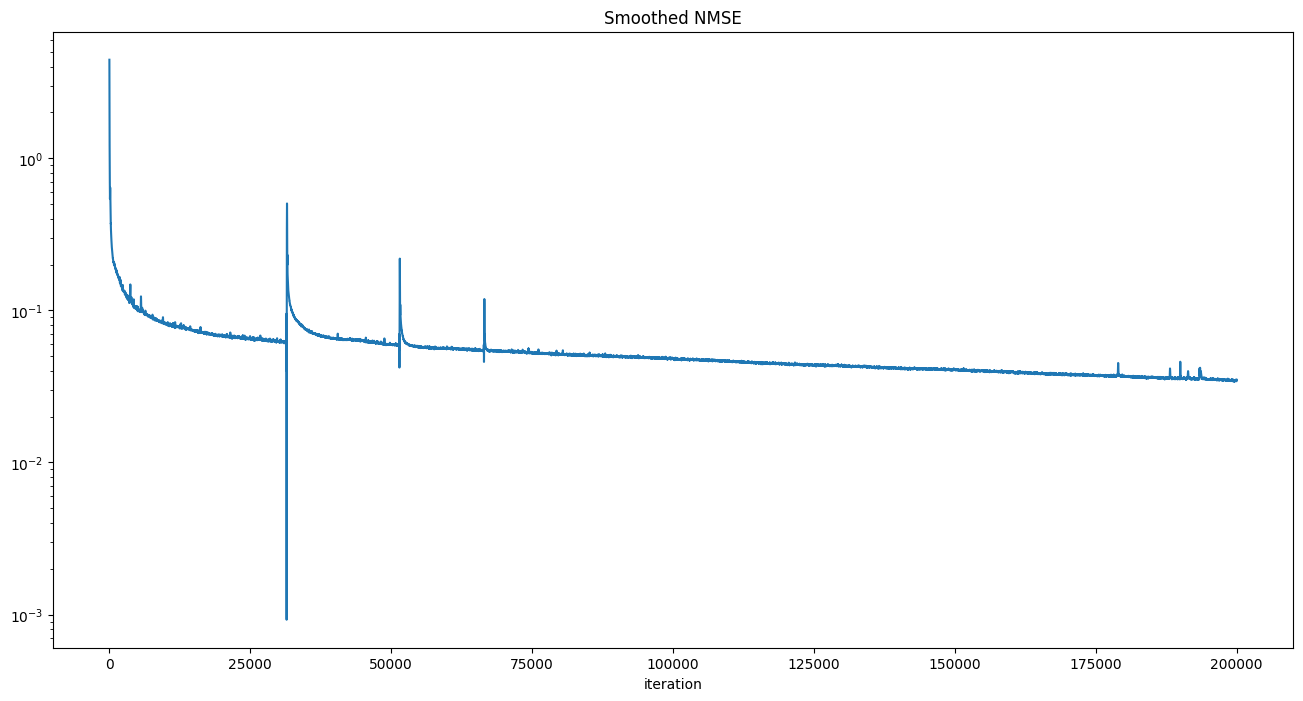

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,1,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE')
ax.set_xlabel('iteration')

## View Reconstructions

In [ ]:
model.eval()

(validation_originals, _) = next(iter(validation_loader))
validation_originals = validation_originals.to(device)

In [ ]:
vq_output_eval = model._pre_vq_conv(model._encoder(validation_originals))
H, W = vq_output_eval.shape[2], vq_output_eval.shape[3]
# validation_representation = model._dl(vq_output_eval) # dictionary learning input dim: (batch_size, N, D), N = H * W (number of pixels), D = embedding_dim (data dimension)
# loss, validation_dict_learned, representation = model._dl.loss(vq_output_eval, validation_representation)
loss, validation_dict_learned, representation = model._dl(vq_output_eval)
print(validation_dict_learned.shape)

torch.Size([32, 256, 8, 8])


In [ ]:
plt.rcParams["figure.figsize"] = (10,8)

In [ ]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

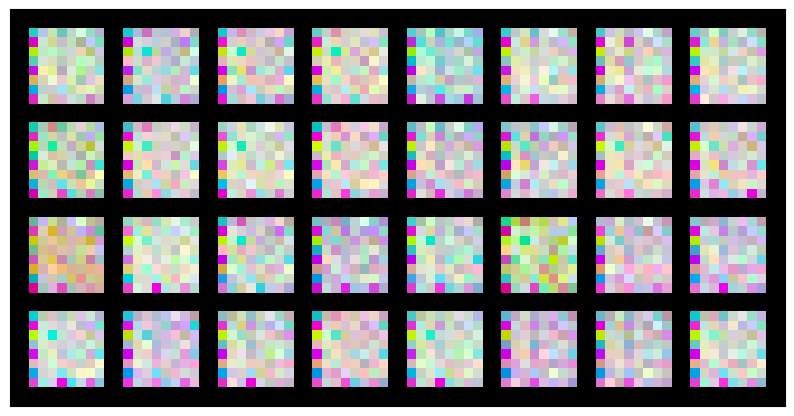

In [ ]:
# Latent space images
latents = validation_dict_learned.view(32 * 64, embedding_dim)
U, S, V = torch.pca_lowrank(latents)
projections = torch.matmul(latents, V[:, :3]).reshape(32, 3, 8, 8) # project to 3 channel space
latent_imgs = projections.cpu().data
for i in range(len(latent_imgs)):
  for j in range(3):
    tmp = latent_imgs[i, j, :, :]
    latent_imgs[i, j, :, :] = (tmp - torch.min(tmp)) / (torch.max(tmp) - torch.min(tmp))
show(make_grid(latent_imgs), )

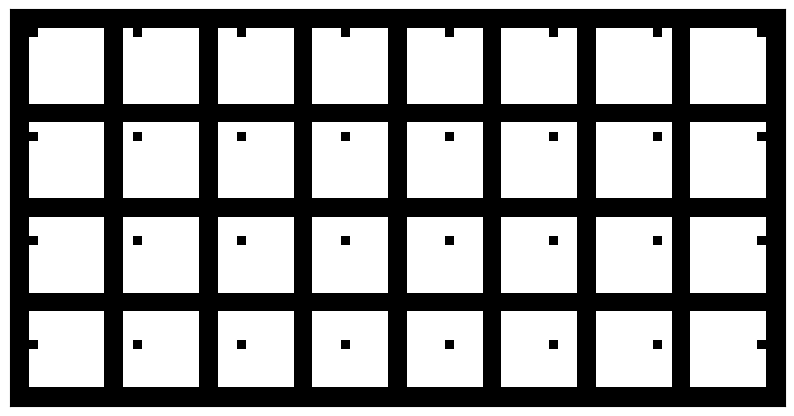

In [ ]:
# create masks
masks = torch.ones((32, 3, 8, 8))
for i, mask in enumerate(masks):
  mask[:, i // 8, i % 8] = 0
show(make_grid(masks))

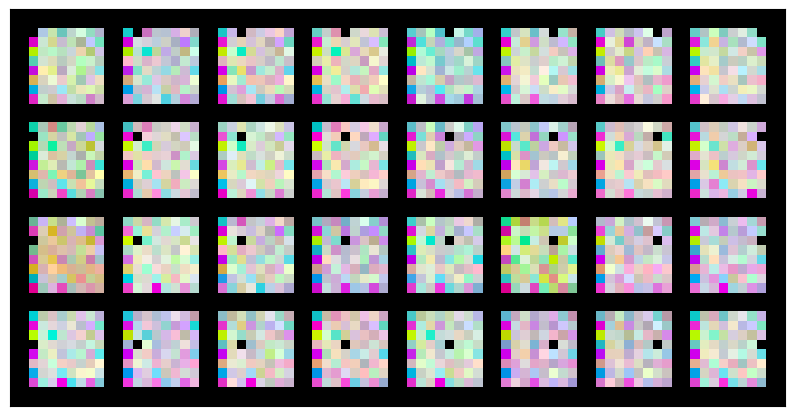

In [ ]:
masked_latent_imgs = torch.mul(masks, latent_imgs)
tmp = masked_latent_imgs

show(make_grid(masked_latent_imgs))

In [ ]:
validation_reconstructions = (model._decoder(validation_dict_learned.reshape(32, embedding_dim, H, W))) # decoder input dim: (batch_size, D, H, W), D = embedding_dim (data dimension), H, W = image height and width in latent space

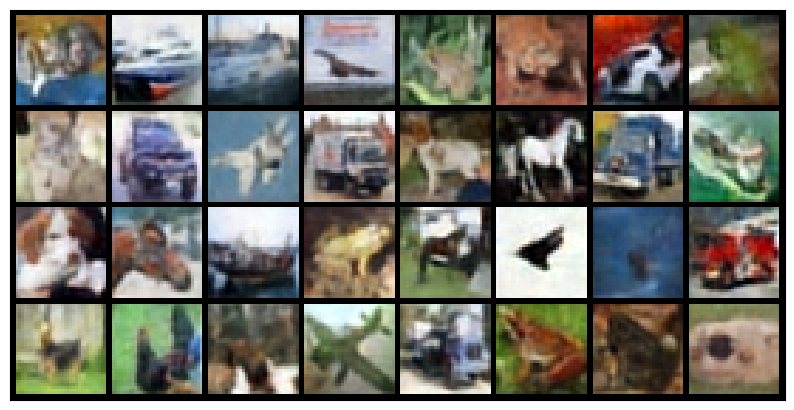

In [ ]:
reconstructed_imgs = validation_reconstructions.cpu().data

for i in range(len(reconstructed_imgs)):
  for j in range(3):
    tmp = torch.clamp(reconstructed_imgs[i, j, :, :], 0, 1)
    reconstructed_imgs[i, j, :, :] = tmp

show(make_grid(reconstructed_imgs), )

In [ ]:
masks = torch.ones((32, embedding_dim, 8, 8))
for i, mask in enumerate(masks):
  mask[:, i // 8, i % 8] = 0
masked_latents = torch.mul(masks.cuda(), latents.reshape(32, embedding_dim, 8, 8))
masked_validation_reconstructions = (model._decoder(masked_latents)) # decoder input dim: (batch_size, D, H, W), D = embedding_dim (data dimension), H, W = image height and width in latent space

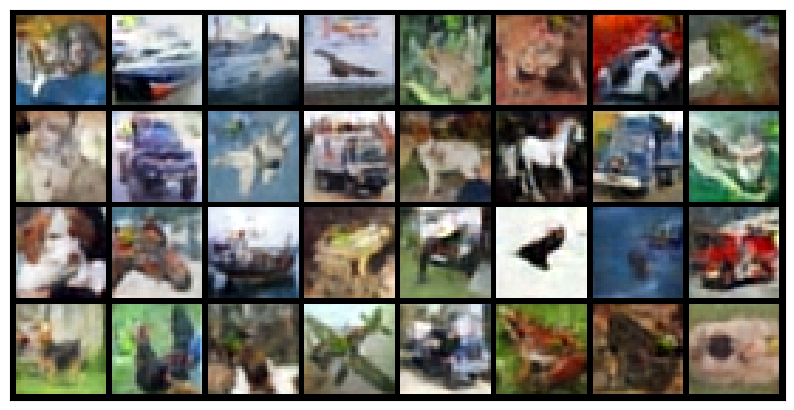

In [ ]:
for i in range(len(masked_validation_reconstructions)):
  for j in range(3):
    tmp = torch.clamp(masked_validation_reconstructions[i, j, :, :], 0, 1)
    masked_validation_reconstructions[i, j, :, :] = tmp

show(make_grid(masked_validation_reconstructions.cpu()))

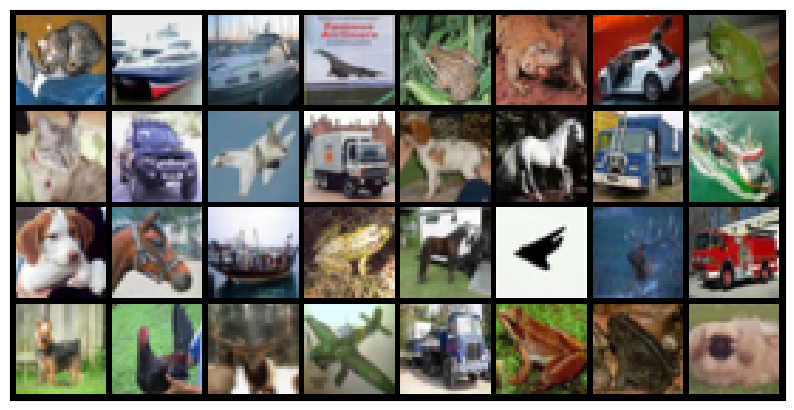

In [ ]:
show(make_grid(validation_originals.cpu()))

We can see the results are decent but a little blurry.

## View Embedding

In [ ]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._dl.dictionary.cpu().detach().numpy())

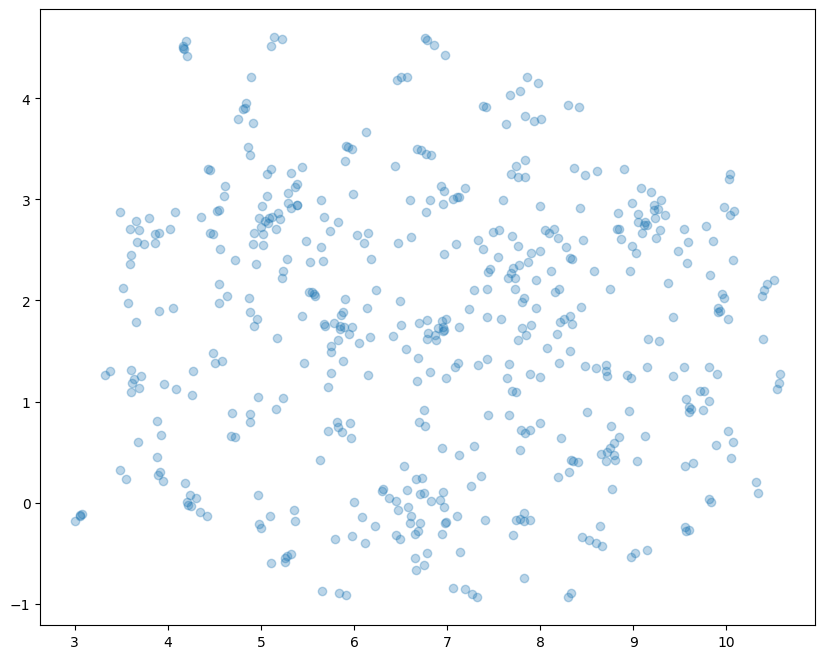

In [ ]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)